# Particle transports with ocean currents

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
import time
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)

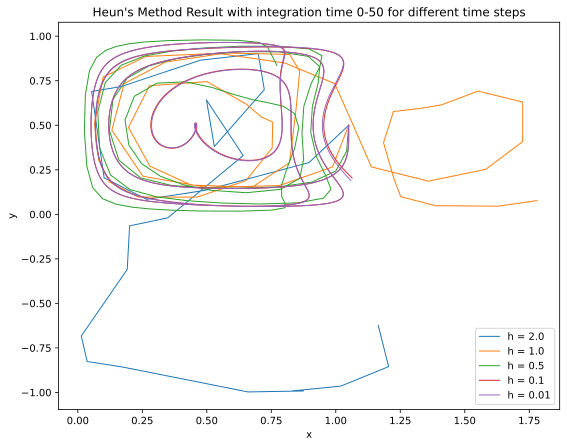

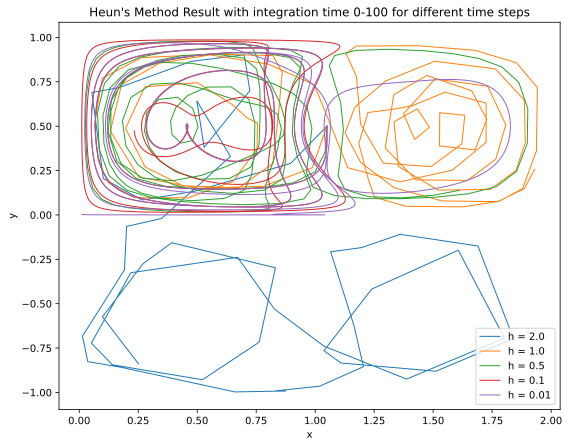

In [127]:
# Oppgave 1a

# Constants
A = 0.1
epsilon = 0.25
w = 1.0

x_0 = np.array([1.05, 0.5])
h = np.array([2, 1, 0.5, 0.1, 0.01])

@njit
def a(t: np.ndarray, epsilon: float, w: float):
    return epsilon * np.sin(w*t)

@njit
def b(t: np.ndarray, epsilon: float, w: float):
    return 1 - 2 * epsilon * np.sin(w*t)

@njit
def f(x: float, t: np.ndarray,):
    return a(t, epsilon, w) * x**2 + b(t, epsilon, w) * x

@njit
def x_dot(x_vec, t, A, epsilon, w):
    v_x = - np.pi * A * np.sin(np.pi * f(x_vec[0],t)) * np.cos(np.pi * x_vec[1])
    v_y = np.pi * A * np.cos(np.pi * f(x_vec[0], t)) * np.sin(np.pi * x_vec[1]) * (a(t, epsilon, w) * 2 * x_vec[0] + b(t, epsilon, w))
    return np.array([v_x, v_y])

@njit
def heuns_method(t: np.ndarray, h: float, epsilon: float, w: float, A: float, x_0: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ''''
    Heun's method for approximating position.
    Takes in a starting posiiton and returns the trajectory. 

    t: time array
    h: step length
    epsilon: parameter
    w: parameter
    A: parameter
    x_0: starting position, 1D array

    '''
    x_arr = np.zeros((len(t), 2))
    x_arr[0] = x_0
    for i in range(len(t)-1):
        k_1 = x_dot(x_arr[i], t[i], A, epsilon, w)
        k_2 = x_dot(x_arr[i] + k_1 * h, t[i] + h, A, epsilon, w)
        x_arr[i+1] = x_arr[i] + h/2 * (k_1 + k_2)
    
    return x_arr[:, 0], x_arr[:, 1]

plt.figure(figsize=(9,7))
for i in range(len(h)):
    t = np.arange(0, 50, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0)
    plt.plot(x, y, label=f"h = {h[i]}", lw=1, markersize=4)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Heun\'s Method Result with integration time 0-50 for different time steps')
plt.legend()
plt.show()

plt.figure(figsize=(9,7))
for i in range(len(h)):
    t = np.arange(0, 100, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0)
    plt.plot(x, y, label=f"h = {h[i]}", lw=1, markersize=4)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Heun\'s Method Result with integration time 0-100 for different time steps')
plt.legend()
plt.show()

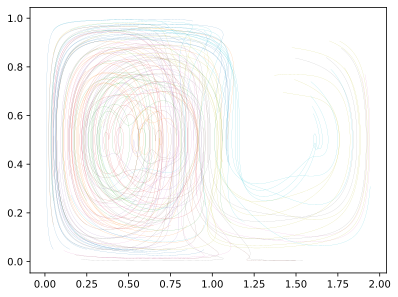

In [129]:
# Oppgave 1b

@njit
def x_dot_new(x_vec: np.ndarray, t: float, A: float, epsilon: float, w: float) -> np.ndarray:
    # Initialize the output velocity array
    v = np.zeros_like(x_vec)
    for i in range(x_vec.shape[0]):
        # Calculate v_x and v_y for each particle
        v[i, 0] = - np.pi * A * np.sin(np.pi * f(x_vec[i, 0], t)) * np.cos(np.pi * x_vec[i, 1])
        v[i, 1] = np.pi * A * np.cos(np.pi * f(x_vec[i, 0], t)) * np.sin(np.pi * x_vec[i, 1]) * (a(t, epsilon, w) * 2 * x_vec[i, 0] + b(t, epsilon, w))
    return v

def heuns_method_mod(t: np.ndarray, h: float, epsilon: float, w: float, A: float, x_0_arr: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    '''
    A modified Heun's method for approximating position. 
    Takes in an array of starting posiitons and returns an array of the trajectories. 

    t: time array
    h: step length
    epsilon: parameter
    w: parameter
    A: parameter
    x_0_arr: array of starting positions, 2D array

    '''
    x_arr = np.zeros((len(t), x_0_arr.shape[0], x_0_arr.shape[1]))
    x_arr[0] = x_0_arr
    for i in range(len(t) - 1):
        k_1 = x_dot_new(x_arr[i], t[i], A, epsilon, w)
        k_2 = x_dot_new(x_arr[i] + k_1 * h, t[i] + h, A, epsilon, w)
        x_arr[i + 1] = x_arr[i] + h / 2 * (k_1 + k_2)
    
    return x_arr

step = 0.01
t = np.arange(0, 10, step)

x_0_arr = np.zeros((100, 2))
for i in range(10):
    for j in range(10):
        x_0_arr[i*10 + j] = np.array([0.05 + i*0.1, 0.05 + j*0.1])

x_arr = heuns_method_mod(t, step, epsilon, w, A, x_0_arr)

for i in range(x_0_arr.shape[0]):
    plt.plot(x_arr[:, i, 0], x_arr[:, i, 1], lw=0.1, markersize=4, label=f'Particle {i}')
